In [135]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gammaln
%matplotlib inline

In [136]:
NORMAL = 0
PRIMED = 1

class Dice(object):
    
    @staticmethod
    def get_fair_distribution():
        return [1./6] * 6
    
    def __init__(self, distribution=None):
        if distribution is None:
            distribution = Dice.get_fair_distribution()
        self.distribution = distribution
    
    def roll(self):
        roll = np.random.multinomial(1, self.distribution)
        return np.argmax(roll) + 1

class Casino(object):

    def __init__(self, K, primed_table_dice_distribution):
        self.normal_tables = np.arange(K)
        self.primed_tables = np.arange(K, 2 * K)

        self.primed_table_dice_distribution = primed_table_dice_distribution
        self.tables = np.append(self.normal_tables, self.primed_tables)

    def is_table_primed(self, table):
        return table in self.primed_tables

    def get_next_table(self, player):
        p = 0.5
        if len(player.visited_tables) != 0:
            p = 1./4 if player.visited_tables[-1] == PRIMED else 3./4

        table_type = np.random.binomial(1, p)
        if table_type == NORMAL or len(self.primed_tables) == 0:
            return self.normal_tables[len(player.visited_tables)]
        else:
            return self.primed_tables[len(player.visited_tables)]

    def roll_table_dice(self, player):
        table = player.current_table
        is_primed = self.is_table_primed(table)
        distribution = [1/6.] * 6 if not is_primed else self.primed_table_dice_distribution
        dice = Dice(distribution)
        return dice.roll()

In [173]:
class Player(object):
    def __init__(self, casino, nr_tables_to_visit, dice):
        self.visited_tables = []
        self.current_table = None
        self.rolls = []
        self.casino = casino
        self.nr_tables_to_visit = nr_tables_to_visit
        self.dice = dice

    def go_to_next_table(self):
        table = self.casino.get_next_table(self)
        self.current_table = table
        self.visited_tables.append(table)

    def roll_dices(self):
        p_roll = self.dice.roll()
        t_roll = self.casino.roll_table_dice(self)
        sum_roll = p_roll + t_roll
        return sum_roll

    def walk_casino(self):
        for _ in xrange(self.nr_tables_to_visit):
            self.go_to_next_table()
            roll = self.roll_dices()
            self.rolls.append(roll)
        return self.rolls

In [174]:
K = 10
N = 5000
c = Casino(K, primed_table_dice_distribution=[5./10] + 5 * [1./10])
players = []
player_dice_distribution = [1./7] * 5 + [2./7]
dice = Dice(player_dice_distribution)
for _ in xrange(N):
    players.append(Player(c, nr_tables_to_visit=K, dice=dice))

all_rolls = []
for n in xrange(N):
    rolls = players[n].walk_casino()
    all_rolls = all_rolls + rolls

# print "all: %s" % all_rolls

(2, 12)

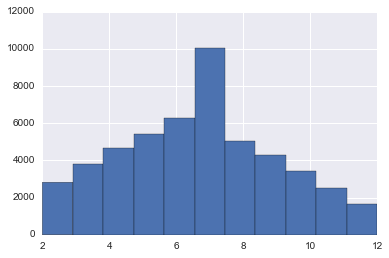

In [175]:
# h = np.histogram2d(np.arange(0, 12), all_rolls)
# print h
n, bins, patches = plt.hist(all_rolls, bins=11)
plt.xlim(2,12)

In [176]:
n = 6
possible_outcomes = np.arange(1, n + 1)
mu = 1./n * np.sum(possible_outcomes)
var = 1./n * np.sum((possible_outcomes - mu)**2)

In [164]:
from numpy import sqrt,pi,vectorize,exp
from scipy.special import gamma

# plotting functions
def plot_1d_pdf(pdf_func, X):
    Y = pdf_func(X)
    plt.plot(X, Y)
    plt.grid()
    plt.show()


def plot_2d_pdf(pdf_func, X, Y):
    Z = pdf_func(*np.meshgrid(X, Y))
    plt.contour(X, Y, Z, linewidths=np.arange(.5, 8, .5))

    plt.xlabel('mu')
    plt.ylabel('sigma')
    plt.axis([-1,1,0,2])
    plt.grid()


# pdf factory functions
def get_gamma_pdf(a, b):
    return vectorize(lambda x: b**a / gamma(a) * x**(a-1) * exp(-x*b))

def get_gaussian_pdf(mu, sigma):
    return vectorize(lambda x: (1. / (sqrt(sigma*2*pi))) * exp(-(x-mu)**2/(2*sigma**2)))


def get_gaussian_gamma_pdf(mu, lamb, a, b):
    const = (b**a)*sqrt(lamb) / (gamma(a) * sqrt(2*pi))
    return vectorize(lambda x, tau: const * tau**(a-0.5) * exp(-b*tau - 0.5*lamb*tau*(x-mu)**2))

def get_vi_gaussian_gamma_pdf(mu, lamb, a, b):
    gamma_pdf = get_gamma_pdf(a, b)
    gaussian_pdf = get_gaussian_pdf(mu, lamb)
    return vectorize(lambda x, tau: gaussian_pdf(x) * gamma_pdf(tau))

def normalGammaPdf(mu, lamb, muprior, kappa, alpha, beta):
    C = (beta ^ alpha * sqrt(kappa)) / (gamma(alpha) * sqrt(2*pi));
    p = C * (lamb**(alpha-1/2)) * (exp(-beta * lamb)) * (exp(-kappa/2* (lamb * (mu - muprior)**2)));
    return p

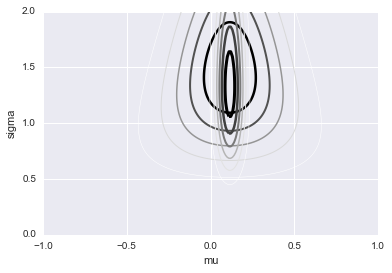

In [165]:
mu0 = 0
var0 = 1.
precision = 1. / (var0**2)

c = 0

N = 10
X = np.random.normal(mu0, var0, N)
muX = np.mean(X)
varX = np.var(X)
s = np.sum(X)
sSq = np.sum(X**2)

# true posterior
a0 = 0
b0 = 0
k0 = 0
mu0 = 0

aNt = a0 + N/2.
bNt = b0 + 1./2*(N*varX + (k0*N*(muX - mu0)**2)/(k0 + N))
mut = (k0*mu0 + N*muX) / (k0 + N)
kNt = k0 + N
  
# initial guess
aN = 2.5
bN = 1.
muN = 0.5
kN = 1.

for i in xrange(100):
    precision = aN/bN
    muN = (k0 * mu0 + N * muX) / (k0 + N)
    kN = (k0 + N) * precision
    
    e_mu = muN
    e_mu2 = 1./kN + muN**2
    aN = a0 + (N + 1)/2.
    bN = b0 + k0 * (e_mu2 + mu0**2 - 2*e_mu*mu0) + 1./2 * np.sum(X**2 + e_mu2 - 2*e_mu*X)
    #bN = b0 + 1./2 * ((sSq + k0 + mu0**2) - 2 * e_mu * (s + k0 * mu0) + e_mu2 * (k0 + N))

x = np.linspace(muN-1.5, muN+1.5, 300)
y = np.linspace(0, 2, 300)
plot_2d_pdf(get_gaussian_gamma_pdf(mut, kNt, aNt, bNt), x, y)
plot_2d_pdf(get_vi_gaussian_gamma_pdf(muN, 1./kN, aN, bN), x, y)
plt.show()

In [449]:
def getA():
    return np.asarray([[1./4, 3./4], [3./4, 1./4]])

def getPi():
    return np.asarray([0.5, 0.5])

def getB(p_dist, c_dist):
    B = np.zeros((2, 13))
    fair = Dice.get_fair_distribution()
    B[NORMAL,:] = np.insert(combineDistributions(p_dist, fair), 0, [0,0])
    B[PRIMED,:] = np.insert(combineDistributions(p_dist, c_dist), 0, [0,0])
    return B

def combineDistributions(d1, d2):
    dist = np.convolve(d1, d2)
    return dist

def getAlpha(O, A, B, pi):
    observation_length = len(O)
    nr_states = 2
    alpha = np.zeros(observation_length * nr_states).reshape(observation_length, nr_states)

    C = [0.] * observation_length
    for i in range(nr_states):
        alpha[0,i] = pi[i] * B[i, O[0]]
        C[0] += alpha[0,i]

    if C[0] != 0:
        C[0] = 1./C[0]
        
    for i in range(nr_states):
        alpha[0][i] *= C[0]
    
    for t in range(1, observation_length):
        C[t] = 0
        for i in range(nr_states):
            alpha[t][i] = 0
            for j in range(nr_states):
                alpha[t,i] += alpha[t-1,j] * A[j,i]

            alpha[t,i] *= B[i, O[t]]
            C[t] += alpha[t,i]

        if C[t] != 0:
            C[t] = 1./C[t]
        
        for i in range(nr_states):
            alpha[t,i] *= C[t]
            
    return alpha

In [474]:
def sampleFromPosterior(O, p_loaded, c_loaded):
    A = getA()
    B = getB(p_loaded, c_loaded)
    pi = getPi()
    alpha = getAlpha(O, A, B, pi)

    nr_states = len(A)
    nr_observations = len(O)

    evidence = 0
    for i in range(nr_states):
        evidence += alpha[-1][i]
        
    p0 = alpha[-1][0] / evidence
    rk = np.random.binomial(1,p0)
    stateSequence = []
    for i in reversed(range(nr_observations-1)):
        rkPrev = []
        for previous in range(nr_states):
            rkPrev.append(A[previous][rk]*alpha[i][previous])
        factor = 0
        for i in range(nr_states):
            factor += rkPrev[i]
        probRkPrev = rkPrev[1]/factor
        stateSequence.append(np.random.binomial(1,probRkPrev))

    stateSequence = stateSequence[::-1]
    stateSequence.append(rk)
    return stateSequence

In [509]:
from scipy import stats

K = 10
N = 1

p_loaded = Dice.get_fair_distribution()#5 * [1./10] + [5./10]
#c_loaded = [5./10] + [1./10] * 5
c_loaded = [5./10] + [5./10] + [0.] * 4

c = Casino(K, primed_table_dice_distribution=c_loaded)
players = []
dice = Dice(p_loaded)
for _ in xrange(N):
    players.append(Player(c, nr_tables_to_visit=K, dice=dice))

all_rolls = []
for n in xrange(N):
    rolls = players[n].walk_casino()
    all_rolls.append(rolls)

print "rolls: %s" % all_rolls
#sample_from_posterior(all_rolls)
actual = map(lambda r: 1 if c.is_table_primed(r) else 0, players[0].visited_tables)
print 'actual: %s' % actual

samples = []
for i in xrange(len(all_rolls)):
    samples.append(sampleFromPosterior(all_rolls[i], p_loaded, c_loaded))
    
print 'guess: %s' % stats.mode(samples)[0]

rolls: [[7, 7, 6, 6, 9, 8, 3, 5, 5, 8]]
actual: [0, 1, 1, 1, 0, 1, 1, 1, 1, 1]
guess: [[1 1 1 0 0 1 1 0 1 0]]
